In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
np.random.seed(20180903)

#### 1. Kalman Filter Class 정의

In [2]:
class KalmanFilter:
    def __init__(self, A, B, Q, H, R):
        self.A = A
        self.B = B
        self.Q = Q
        self.H = H
        self.R = R
    
    def Predict(self, inputs):
        x, P = inputs
        x_pred = np.dot(self.A,x)+self.B
        P_pred = np.dot(np.dot(self.A,P),self.A.T) + self.Q
        return x_pred, P_pred
    
    def Update(self, update, z_meas):
        x_pred, P_pred = update
        z_pred = np.dot(self.H, x_pred)
        v = z_meas.reshape(-1,1) - z_pred
        F = np.dot(np.dot(self.H, P_pred),self.H.T) + self.R
        K = np.dot(np.dot(P_pred, self.H.T), linalg.inv(F))
        x_update = x_pred + np.dot(K, v)
        P_update = P_pred - np.dot(np.dot(K, self.H), P_pred)
        dF = linalg.det(F)
        if dF <= 0:
            print('Warning : dF <= 0 인 경우가 있습니다.')
            dF = 1e-70
        logL = -0.5*np.log(2*np.pi) - 0.5*np.log(dF) - 0.5* np.dot(v.T, np.dot(linalg.inv(F), v))
        # -logL를 minimize 해야 함
        return x_update, P_update, -logL[0][0]

#### 2. 데이터 입력

In [3]:
data = np.array(pd.read_csv('./data/KIS_spot_continuous_montly_201612.csv'))

In [4]:
# System
def set_param(param):
        dt = 1/12
        tau = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5, 7, 10, 15, 20]
        lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma1, sigma2, sigma3, rho12, rho13, rho23 = param
        
        # κ > 0 이라는 조건 때문에 넣음
        kappa1 = abs(kappa1)
        kappa2 = abs(kappa2)
        kappa3 = abs(kappa3)
        
        # 상태 입력
        A = np.array([[1-kappa1*dt, 0, 0],
                      [0, 1-kappa2*dt, 0],
                      [0, 0, 1-kappa3*dt]])
        B = np.array([[kappa1*theta1],
                      [kappa2*theta2],
                      [kappa3*theta3]])
        Q = np.array([[sigma1**2, sigma1*sigma2*rho12, sigma1*sigma3*rho13],
                      [sigma1*sigma2*rho12, sigma2**2, sigma2*sigma3*rho23],
                      [sigma1*sigma3*rho13, sigma2*sigma3*rho23, sigma3**2]])
        H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])
        R = np.identity(len(tau))*eps**2
        
        return A, B, Q, H, R

In [5]:
def get_states(kf, data):
    # Input Initial State
    x0 = np.array([0.06,-0.02,0]).reshape(-1,1)
    P0 = np.identity(3)*10
    
    n = data.shape[0]
    states = np.zeros([n+1,3])
    states[0] = x0.reshape(3)
    
    for i in range(n):
        x1, P1 = kf.Predict([x0, P0])
        x0, P0, ll = kf.Update([x1, P1], data[i,:])
        states[i+1] = x0.reshape(3)
    return states

In [6]:
def get_loglik(kf, data):
    # Input Initial State
    x0 = np.array([0.06,-0.02,0]).reshape(-1,1)
    P0 = np.identity(3)*10
    
    n = data.shape[0]
    loglik = np.zeros(n)
    
    for i in range(n):
        x1, P1 = kf.Predict([x0, P0])
        x0, P0, ll = kf.Update([x1, P1], data[i,:])
        loglik[i] = ll
    return loglik.sum()

In [7]:
def obj(param):
    A,B,Q,H,R = set_param(param)
    kf = KalmanFilter(A,B,Q,H,R)
    res = get_loglik(kf,data)
    if np.random.randint(500) == 0:
        print('Loglikelihood is... : {}'.format(-res))
    return res

#### 3. 모수 최적화

In [8]:
# Optimization
param = np.loadtxt('param.txt')
res = minimize(fun=obj, x0=param, method='nelder-mead', options={'disp': True, 'maxiter':1000})

Loglikelihood is... : 11279.475886718377
Loglikelihood is... : 11279.44547093544
Loglikelihood is... : 11279.435720305268
Loglikelihood is... : 11279.468764967609
Loglikelihood is... : 11279.540710744019
Optimization terminated successfully.
         Current function value: -11279.540711
         Iterations: 315
         Function evaluations: 1068


In [9]:
np.savetxt('param.txt', res.x)
print('lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma1, sigma2, sigma3, rho12, rho13, rho23')
print([round(x, 4) for x in param])

lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma1, sigma2, sigma3, rho12, rho13, rho23
[0.5588, 0.0005, 0.0266, 0.3114, 1.3563, -0.0047, -0.0013, -0.0006, 0.0021, 0.0029, 0.0052, -0.645, -0.0071, -0.0181]


#### 4. 충격 시나리오

In [10]:
# 상태 입력
lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma1, sigma2, sigma3, rho12, rho13, rho23 = param
dt = 1/12

kappa = np.array([kappa1,kappa2,kappa3]).reshape(-1,1)
theta = np.array([theta1,theta2,theta3]).reshape(-1,1)
Q = np.array([[sigma1**2, sigma1*sigma2*rho12, sigma1*sigma3*rho13],
              [sigma1*sigma2*rho12, sigma2**2, sigma2*sigma3*rho23],
              [sigma1*sigma3*rho13, sigma2*sigma3*rho23, sigma3**2]])
S = linalg.cholesky(Q)

array([[ 0.0231647 ],
       [-0.00930381],
       [-0.00458337]])

In [20]:
X0 = states[-1].reshape(-1,1)
M = np.dot(1/kappa*np.identity(3)*(1-np.exp(-kappa)),S)

LOT = 20
N0 = np.sum(np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in range(1,LOT+1)]), axis=0)
N = np.dot(N0*np.identity(3), M)
eig_values, E = np.linalg.eig(np.dot(N.T, N))

e1 = E[:,0].reshape(3,1)
e2 = E[:,1].reshape(3,1)
S1 = np.dot(N0,np.dot(M, e1))[0]
S2 = np.dot(N0,np.dot(M, e2))[0]
arg = np.arctan(S2/S1)

# 충격 산출
T = np.dot(np.identity(3)*(1-np.exp(-kappa)), theta - X0)
Level = (np.cos(arg)*np.dot(M,e1) + np.sin(arg)*np.dot(M,e2))*norm.ppf(0.995)
Twist = (np.cos(arg)*np.dot(M,e2) - np.sin(arg)*np.dot(M,e1))*norm.ppf(0.995)

#### 5. PCA

In [21]:
data2 = np.log(data[1:]/data[:-1])
scaler = StandardScaler(with_std=False).fit(data2)
scaled = scaler.transform(data2)
cov = np.dot(scaled.T, scaled)/(len(data2)-1)
vals, vecs = linalg.eig(cov)
lev1 = np.exp(norm.ppf(0.995)*np.sqrt(vals[0]*12)*vecs[:,0])-1
lev2 = np.exp(-norm.ppf(0.995)*np.sqrt(vals[0]*12)*vecs[:,0])-1
twi1 = np.exp(norm.ppf(0.995)*np.sqrt(vals[1]*12)*vecs[:,1])-1
twi2 = np.exp(-norm.ppf(0.995)*np.sqrt(vals[1]*12)*vecs[:,1])-1

#### 6. 시각화

In [22]:
#lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma1, sigma2, sigma3, rho12, rho13, rho23
#param  = [0.476171777,0.000316078,0.10081914,0.384169765,0.309295422,
#         0.033407021,-0.017656271,0.005049516,0.0061813,0.0066468,0.01078,-0.005674491,
#         0.000739791,-0.000826842]

In [23]:
# Result
A,B,Q,H,R = set_param(param)
kf = KalmanFilter(A,B,Q,H,R)
states = get_states(kf, data)
lambda_ = param[0]
tau = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5, 7, 10, 15, 20]
H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])

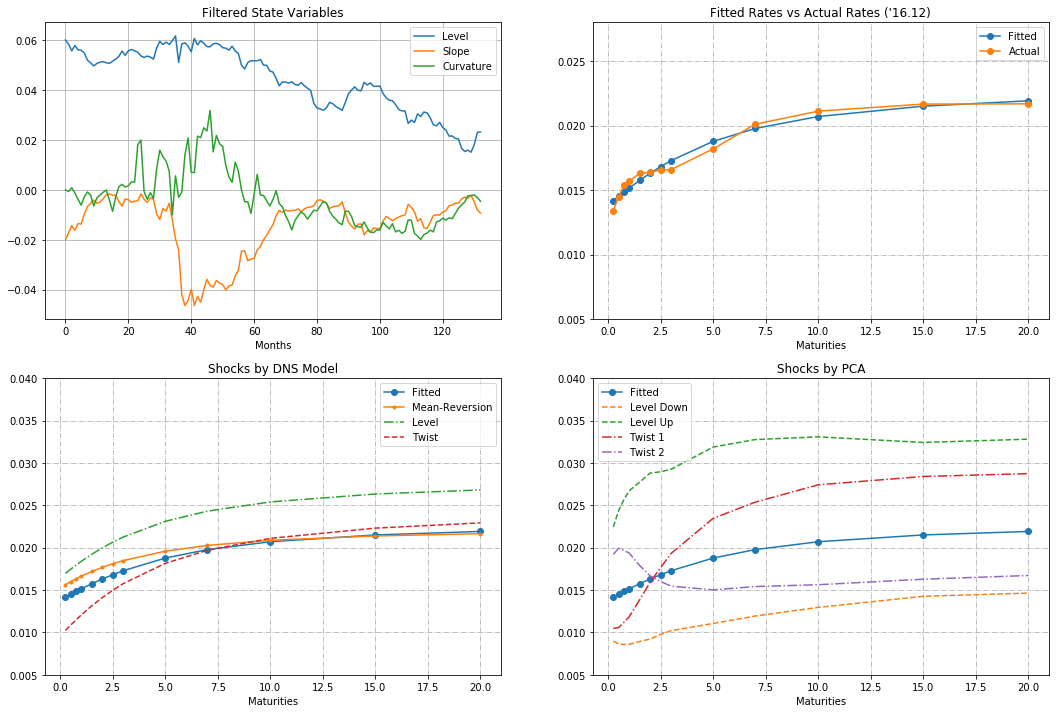

In [24]:
# Visualization
fig, ax = plt.subplots(2,2, figsize=(18,12))

# Filtered State Variables
titles = ['Level', 'Slope', 'Curvature']
for i in range(3):
    ax[0][0].plot(states[:,i], label=titles[i])
ax[0][0].set_xlabel('Months')
ax[0][0].set_title('Filtered State Variables')
ax[0][0].grid()
ax[0][0].legend()

i = -1
# Fitted Rates vs Actual Rates
# 2006년 1월 = 0, 2006년 2월 = 1 ...
ax[0][1].plot(tau, np.dot(H, states[i]), '-o', label='Fitted')
ax[0][1].plot(tau, data[i,], '-o', label='Actual')
ax[0][1].set_xlabel('Maturities')
ax[0][1].legend()
ax[0][1].set_title('Fitted Rates vs Actual Rates (\'16.12)')
ax[0][1].grid(True, linestyle='-.')
ax[0][1].set_ylim([0.005,0.028])

# DNS Shocks
ax[1][0].plot(tau, np.dot(H, states[i]), '-o', label='Fitted')
ax[1][0].plot(tau, np.dot(H, states[i]+T.reshape(3)), '.-', label='Mean-Reversion')
ax[1][0].plot(tau, np.dot(H, states[i]+Level.reshape(3)), '-.', label='Level')
ax[1][0].plot(tau, np.dot(H, states[i]+Twist.reshape(3)), '--', label='Twist')
ax[1][0].set_xlabel('Maturities')
ax[1][0].set_title('Shocks by DNS Model')
ax[1][0].grid(True, linestyle='-.')
ax[1][0].set_ylim([0.005,0.04])
ax[1][0].legend()

# PCA Shocks
ax[1][1].plot(tau, np.dot(H, states[i]), '-o', label='Fitted')
ax[1][1].plot(tau, np.dot(H, states[i])*(1+lev1), '--', label='Level Down')
ax[1][1].plot(tau, np.dot(H, states[i])*(1+lev2), '--', label='Level Up')
ax[1][1].plot(tau, np.dot(H, states[i])*(1+twi1), '-.', label='Twist 1')
ax[1][1].plot(tau, np.dot(H, states[i])*(1+twi2), '-.', label='Twist 2')
ax[1][1].set_xlabel('Maturities')
ax[1][1].set_title('Shocks by PCA')
ax[1][1].grid(True, linestyle='-.')
ax[1][1].set_ylim([0.005,0.04])
ax[1][1].legend()

plt.show()